In [9]:
%matplotlib nbagg

import pymc
from __future__ import division
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

*Please note: much of the inspiration for this article was taken from the wonderful series of notebooks (later made into the book Bayesian Methods for Hackers by Cameron Davidson-Pilon) found [here](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb).*

Imagine you have a time series - perhaps something like customer sales - and you want to see whether there has been any effect of something like a promotion. How would you do it?

Well, a first approach might involve eyeballing the data and seeing if there's any uptick in activity. But what if your data is very noisy? Your eyes might not be so great at recognising a change.

A more sophisticated approach might involve Bayesian Inference. Ooooooooh. The idea is to use an initial belief about what the distribution of sales might look like before and after the promotion (and when the promotion might have occurred). We then update these beliefs with the real data. 

By real data, I do, of course mean made up data. Here is a time series of "sales data". The sales are dictated by one normal distribution before the "promotion", and another normal distribution after the "promotion":

<IPython.core.display.Javascript object>


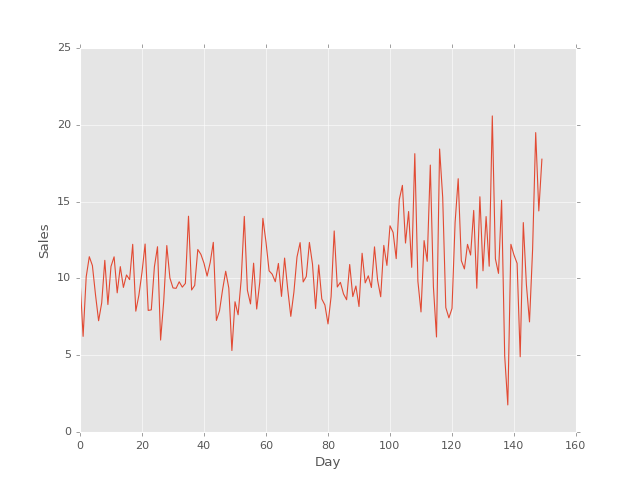

In [43]:
x1 = norm.rvs(scale = 2, loc = 10, size = 100)
x2 = norm.rvs(scale = 4, loc = 12, size = 50)
x = np.concatenate((x1,x2))

fig, ax = plt.subplots()
ax.plot(x)
ax.set_xlabel('Day')
ax.set_ylabel('Sales')

Now if this were a real data set - we wouldn't know what the standard deviation $\sigma$ or the mean $\mu$ of these normal distributions is (let's call it day $X$). Nor would we know at which day we switched on the promotion. We may not even know that these data were coming from a normal distribution (although we might be able to hazard a good guess).

So the crux of the problem is this: we need to work out $\mu_1$, $\mu_2$, $\sigma_1$ and $\sigma_2$ for the two distributions, and day $X$ for the start of the promotion. 

We start doing that by making an assumption about what these various variables could be. A good start would be the average value for both $\mu$, and the overall standard deviation for both $\sigma$. But we're not absolutely sure that these are the correct variables, so we assign some uncertainty on either side of the averages by way of a uniform function.

In [55]:
mean = np.mean(x)
std = np.std(x)
tau = 1 / (std**2)
print mean
print std
print tau

10.6227638839
2.81806020093
0.125921377801


Note that PyMC's Normal function that we'll be using later uses $\tau$, which is the inverse of the variance, rather than $\sigma$, the standard deviation, as its input.

In [67]:
mu1 = pymc.Uniform(name = "mu1", lower = 0, upper = 30)
mu2 = pymc.Uniform("mu2", 0, 30)
tau1 = pymc.Uniform("tau1", 0, 1)
tau2 = pymc.Uniform("tau2", 0, 1)

In [68]:
X = pymc.DiscreteUniform("X", lower=0, upper=len(x))

<IPython.core.display.Javascript object>


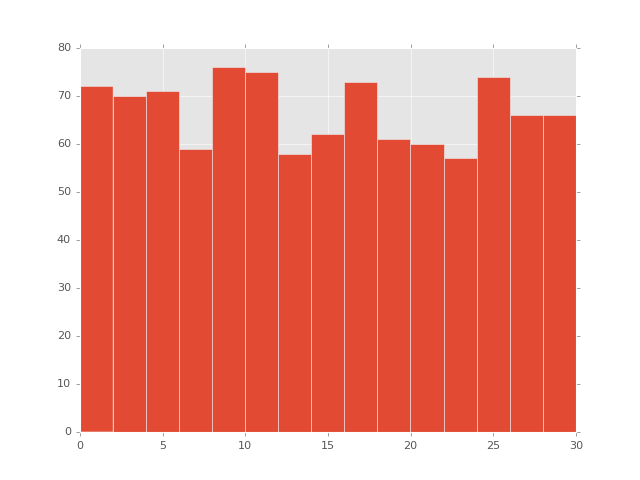

In [69]:
mu1_array = []
for i in range(1000):
    mu1_array.append(mu1.random())
    
fig, ax = plt.subplots()
h = ax.hist(mu1_array, bins = 15)

In [70]:
@pymc.deterministic
def mu_(X=X, mu1=mu1, mu2=mu2):
    out = np.zeros(len(x))
    out[:X] = mu1
    out[X:] = mu2
    return out

@pymc.deterministic
def tau_(X=X, tau1=tau1, tau2=tau2):
    out = np.zeros(len(x))
    out[:X] = tau1
    out[X:] = tau2
    return out

In [71]:
observation = pymc.Normal("obs", mu_, tau_, value=x, observed=True)

In [72]:
model = pymc.Model({"obs": observation, "mu1": mu1, "mu2": mu2, "tau1": tau1, "tau2": tau2, "X": X})

In [73]:
mcmc = pymc.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 10.8 sec

In [74]:
mu1_samples = mcmc.trace('mu1')[:]
mu2_samples = mcmc.trace('mu2')[:]
tau1_samples = mcmc.trace('tau1')[:]
tau2_samples = mcmc.trace('tau2')[:]
X_samples = mcmc.trace('X')[:]

<IPython.core.display.Javascript object>


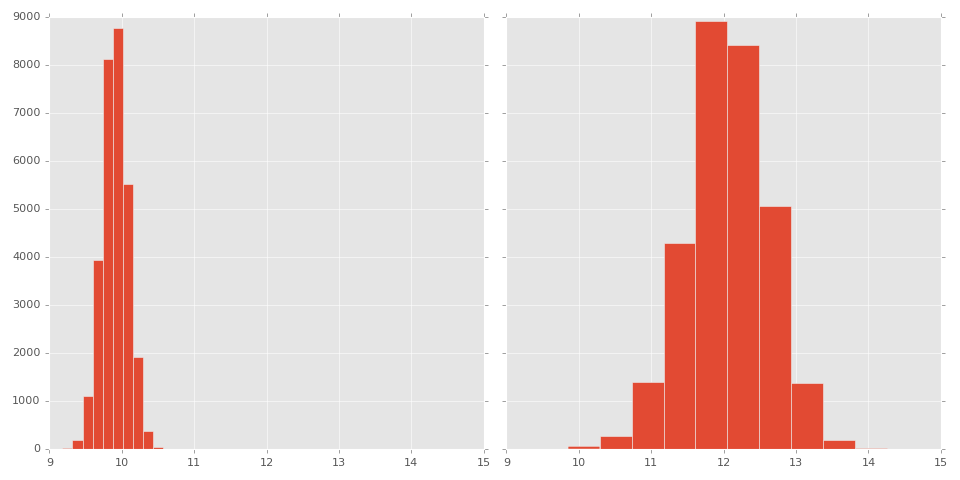

In [75]:
fig, axs = plt.subplots(ncols=2, figsize = (12,6), sharex=True, sharey=True)

axs[0].hist(mu1_samples)
axs[1].hist(mu2_samples)

plt.tight_layout()

<IPython.core.display.Javascript object>


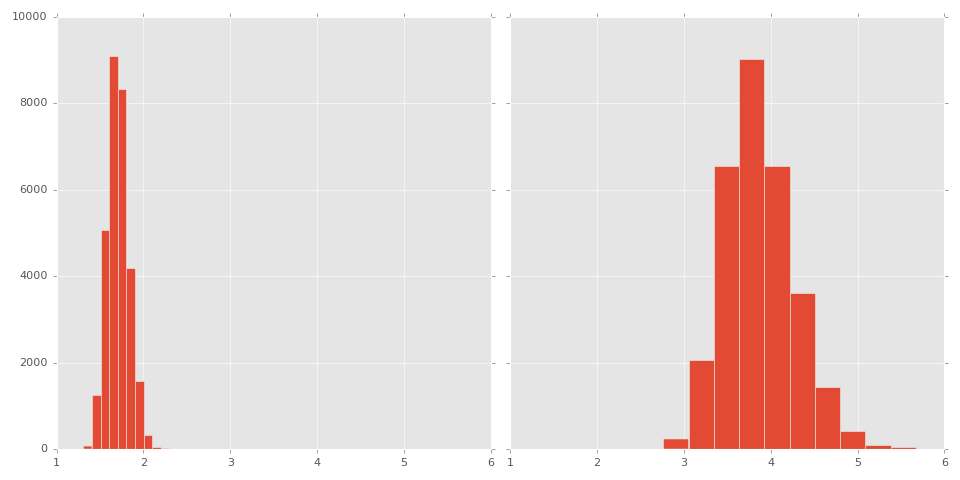

In [76]:
fig, axs = plt.subplots(ncols=2, figsize = (12,6), sharex=True, sharey=True)

axs[0].hist(1/ np.sqrt(tau1_samples))
axs[1].hist(1/np.sqrt(tau2_samples))

plt.tight_layout()

<IPython.core.display.Javascript object>


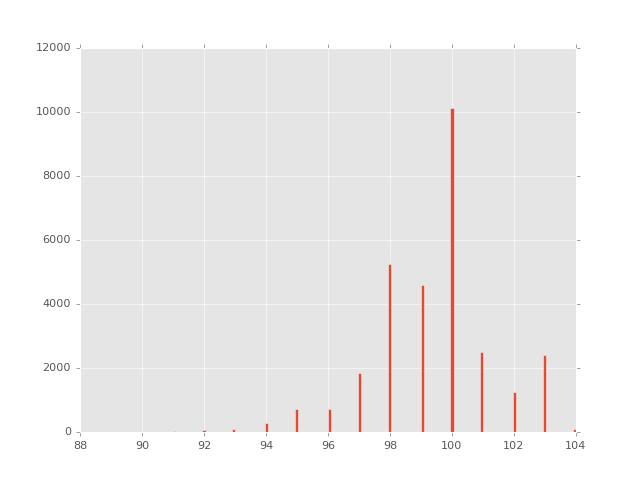

In [79]:
fig, ax = plt.subplots()

hist = ax.hist(X_samples, bins = len(x))